## Imports / Helper Functions / Global Variables

In [123]:
# force geopandas to use shapely instead of pygeos
import os
os.environ['USE_PYGEOS'] = '0'

import numpy as np
import pandas as pd
import plotly.express as px
from shapely import wkt
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt
from pyproj import Transformer
from typing import List
from collections import Counter
import seaborn as sns
from tqdm import tqdm

In [181]:
import shapely

shapely.__version__

'2.0.1'

In [2]:
# shorthand for datetime column

DATE_COL = 'Citation Issued DateTime'

In [25]:
# datetime manipulation helper functions

def filter_by_date_range(df: pd.DataFrame, column_name: str, start_string: str, end_string: str):
    return df[(df[column_name] >= pd.Timestamp(start_string)) & (df[column_name] <= pd.Timestamp(end_string))]

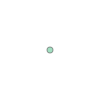

In [3]:
# helper functions for loading in US Census Bureau Geocoding data. This helps correct for ~10k observations with incorrect geolocation.

# 1ST -> 01ST, 2ND -> 02ND, etc., to be compatible
def inv_correct_numbered_streets(string):
    for i in range(1, 10):
        string = string.replace(f'{i}TH', f'0{i}TH')
    # 1st, 2nd and 3rd are special cases
    string = string.replace('1ST', '01ST')
    string = string.replace('2ND', '02ND')
    string = string.replace('3RD', '03RD')
    return string

def coord_string_to_point(coord_string):
    x, y = [float(string) for string in coord_string.split(',')]
    return Point(x, y)

coord_string_to_point("-122.46164710599999,37.77421091000008")

In [ ]:
# TODO: correct all "lock Of" addresses.

# feat_df[feat_df.street_id.str.contains('lock Of')]

In [5]:
def load_geocoder_data(csv_path='../data/chinook_ct_correct.csv'):
    geo = pd.read_csv(csv_path, header=None)
    geo = geo[geo[2] == 'Match']
    geo[1] = geo[1].str.replace(', SAN FRANCISCO, CA,', '').apply(lambda x: x.strip())
    geo = geo[[1, 5]]
    geo.columns = ['street', 'geom']
    geo.street = geo.street.apply(inv_correct_numbered_streets)
    geo.geom = geo.geom.apply(coord_string_to_point)
    return geo

## Load Data and Fix Incorrect Data

In [7]:
geo_df = load_geocoder_data()
geo_df.head()

,street,geom
0,785 04TH AVE,POINT (-122.46164710599999 37.77421091000008)
1,756 08TH AVE,POINT (-122.46593421399996 37.77422294300004)
2,277 05TH AVE,POINT (-122.46339279499995 37.783491569000034)
3,404 08TH AVE,POINT (-122.46639889099998 37.78064289800005)
4,398 05TH ST,POINT (-122.40188964199996 37.77906450900008)


In [13]:
# create dictionary from pandas dataframe. 

geo_dict = pd.Series(geo_df.geom.values,index=geo_df.street).to_dict()

In [10]:
geo_df.shape

(2500, 2)

In [19]:
df = pd.read_csv("../data/data_2022_with_geom.csv")
df.head()

,Citation Number,Citation Issued DateTime,Violation,Violation Description,Citation Location,Vehicle Plate State,Vehicle Plate,Fine Amount,Date Added,geom
0,950226616,04/20/2022 12:10:00 PM,TRC7.2.22,STR CLEAN,1318 FILBERT ST,CA,V507699,84.0,05/01/2022 12:00:00 AM,POINT (-122.42119800399996 37.800016984000024)
1,952126114,06/17/2022 04:12:00 PM,TRC7.2.20,RES/OT,1318 FILBERT ST,CA,BV44D97,96.0,07/17/2022 12:00:00 AM,POINT (-122.42119800399996 37.800016984000024)
2,950441903,04/23/2022 03:13:00 PM,V5200,NO PLATES,1318 FILBERT ST,CA,V507699,121.0,05/18/2022 12:00:00 AM,POINT (-122.42119800399996 37.800016984000024)
3,948460144,02/22/2022 11:54:00 AM,TRC7.2.20,RES/OT,1318 FILBERT ST,TX,HVT6737,96.0,05/23/2022 12:00:00 AM,POINT (-122.42119800399996 37.800016984000024)
4,948169644,02/17/2022 01:39:00 PM,TRC7.2.20,RES/OT,1318 FILBERT ST,OH,HQA6554,96.0,04/03/2022 12:00:00 AM,POINT (-122.42119800399996 37.800016984000024)


In [20]:
df['geom'] = df.geom.apply(wkt.loads)
df = gpd.GeoDataFrame(df, geometry='geom')
df.crs = 'EPSG:4326'

In [21]:
# TODO: rewrite this using np.where or pandas where 
# TODO: use a better geocoder to fix more rows.

def fix_geom(row):
    if row['Citation Location'] in geo_dict:
        return geo_dict[row['Citation Location']]
    return row['geom']

df['geom'] = df.apply(fix_geom, axis=1)

## Add / Modify Dataframe Columns

In [22]:
df[DATE_COL] = pd.to_datetime(df[DATE_COL])

In [23]:
# add auxillary date attribute columns based on the datetime. 

df['citation_day'] = df[DATE_COL].dt.day_name()
df['citation_hour'] = df[DATE_COL].dt.hour
df['citation_date'] = df[DATE_COL].dt.date

In [24]:
has_location_string = df[~df['Citation Location'].isnull()]

## Spatial Join

In [182]:
# load dataframe of street segments

street_df = pd.read_csv('../data/street_sweeping.csv')
street_df = street_df[~street_df.Line.isnull()]
street_df.loc[:, 'Line'] = street_df.Line.apply(wkt.loads)
street_df = gpd.GeoDataFrame(street_df, geometry='Line')
street_df.crs = 'EPSG:4326'

In [183]:
# TODO: technically should project into a flat geometry in order to get more accurate distances  

unique_streets = street_df.drop_duplicates(subset='Line')
unique_streets = unique_streets[['Corridor', 'Limits', 'Line']]

# save copy of geom column because it will be destroyed by projection / join.
unique_streets['street_geom_3d'] = unique_streets['Line']
unique_streets['street_length'] = unique_streets.street_geom_3d.apply(lambda x: x.length)

In [185]:
unique_streets.to_csv('../data/unique_streets.csv')

In [39]:
joined = gpd.sjoin_nearest(df, unique_streets, distance_col='dist', how='left')
joined.shape

/Users/bryanwang/opt/miniconda3/envs/stat-222/lib/python3.9/site-packages/geopandas/array.py:344: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


(1063988, 19)

In [ ]:
# TODO: figure out how to resolve points that get mapped to multiple streets. for now, seems like only a small number have this problem so we ignore it.

has_multiple_citations = joined['Citation Number'].value_counts()
joined = joined[joined['Citation Number'].isin(has_multiple_citations[has_multiple_citations == 1].index)]

## Group and Cluster

In [186]:
unique_streets

,Corridor,Limits,Line,street_geom_3d,street_length
0,Mission St,Julia St - 08th St,"LINESTRING (-122.41241 37.77805, -122.41316 37...","LINESTRING (-122.41241 37.77805, -122.41316 37...",0.000949
1,22nd St,Mission St - Bartlett St,"LINESTRING (-122.41875 37.75544, -122.41986 37...","LINESTRING (-122.41875 37.75544, -122.41986 37...",0.001113
2,Congdon St,Maynard St - Silver Ave,"LINESTRING (-122.42602 37.72940, -122.42596 37...","LINESTRING (-122.42602 37.72940, -122.42596 37...",0.000758
3,Sparta St,Ankeny St - Harkness Ave,"LINESTRING (-122.40355 37.71834, -122.40347 37...","LINESTRING (-122.40355 37.71834, -122.40347 37...",0.000872
4,Van Ness Ave,Golden Gate Ave - Turk St,"LINESTRING (-122.42044 37.78103, -122.42055 37...","LINESTRING (-122.42044 37.78103, -122.42055 37...",0.001009
...,...,...,...,...,...
37676,Lincoln Way,11th Ave - 12th Ave,"LINESTRING (-122.46858 37.76583, -122.46870 37...","LINESTRING (-122.46858 37.76583, -122.46870 37...",0.001089
37691,Alemany Blvd,Theresa St - Cotter St,"LINESTRING (-122.43448 37.72873, -122.43448 37...","LINESTRING (-122.43448 37.72873, -122.43448 37...",0.000792
37761,Noriega St,16th Ave - 17th Ave,"LINESTRING (-122.47326 37.75438, -122.47338 37...","LINESTRING (-122.47326 37.75438, -122.47338 37...",0.001091
37796,Diamond Heights Blvd,Diamond St - Berkeley Way,"LINESTRING (-122.43740 37.73829, -122.43747 37...","LINESTRING (-122.43740 37.73829, -122.43747 37...",0.002202


In [44]:
joined['street_id'] = joined['Corridor'] + ' ' + joined['Limits']

In [50]:
feat_df = joined[['citation_date', 'street_id', DATE_COL, 'Citation Location', 'geom', 'citation_day', 'citation_hour', 'street_geom_3d']]

In [189]:
unique_streets[['X1', 'Y1']] = unique_streets['Line'].apply(lambda x: pd.Series([x.coords[0][0], x.coords[0][1]]))
unique_streets[['X2', 'Y2']] = unique_streets['Line'].apply(lambda x: pd.Series([x.coords[1][0], x.coords[1][1]]))

unique_streets['Endpoint1'] = unique_streets['X1'].astype(str) + " " + unique_streets['Y1'].astype(str)
unique_streets['Endpoint2'] = unique_streets['X2'].astype(str) + " " + unique_streets['Y2'].astype(str)

In [191]:
unique_streets['segment_id'] = unique_streets['Corridor'] + ' ' + unique_streets['Limits']

In [192]:
unique_streets

,Corridor,Limits,Line,street_geom_3d,street_length,X1,Y1,X2,Y2,Endpoint1,Endpoint2,segment_id
0,Mission St,Julia St - 08th St,"LINESTRING (-122.41241 37.77805, -122.41316 37...","LINESTRING (-122.41241 37.77805, -122.41316 37...",0.000949,-122.412413,37.778045,-122.413158,37.777457,-122.412413343787 37.778045328617,-122.413157691449 37.777457419935,Mission St Julia St - 08th St
1,22nd St,Mission St - Bartlett St,"LINESTRING (-122.41875 37.75544, -122.41986 37...","LINESTRING (-122.41875 37.75544, -122.41986 37...",0.001113,-122.418748,37.755437,-122.419858,37.755366,-122.418747573844 37.75543693624,-122.419857942892 37.755365729245,22nd St Mission St - Bartlett St
2,Congdon St,Maynard St - Silver Ave,"LINESTRING (-122.42602 37.72940, -122.42596 37...","LINESTRING (-122.42602 37.72940, -122.42596 37...",0.000758,-122.426025,37.729397,-122.425964,37.728641,-122.42602470434 37.72939698234,-122.42596370352 37.72864102171,Congdon St Maynard St - Silver Ave
3,Sparta St,Ankeny St - Harkness Ave,"LINESTRING (-122.40355 37.71834, -122.40347 37...","LINESTRING (-122.40355 37.71834, -122.40347 37...",0.000872,-122.403555,37.718337,-122.403470,37.718197,-122.403554923986 37.718336652479,-122.403470376794 37.718196907433,Sparta St Ankeny St - Harkness Ave
4,Van Ness Ave,Golden Gate Ave - Turk St,"LINESTRING (-122.42044 37.78103, -122.42055 37...","LINESTRING (-122.42044 37.78103, -122.42055 37...",0.001009,-122.420440,37.781031,-122.420552,37.781126,-122.420439517797 37.781030842108,-122.420552025357 37.781125672257,Van Ness Ave Golden Gate Ave - Turk St
...,...,...,...,...,...,...,...,...,...,...,...,...
37676,Lincoln Way,11th Ave - 12th Ave,"LINESTRING (-122.46858 37.76583, -122.46870 37...","LINESTRING (-122.46858 37.76583, -122.46870 37...",0.001089,-122.468583,37.765830,-122.468704,37.765778,-122.468582998602 37.765830028099,-122.468704484779 37.765777895744,Lincoln Way 11th Ave - 12th Ave
37691,Alemany Blvd,Theresa St - Cotter St,"LINESTRING (-122.43448 37.72873, -122.43448 37...","LINESTRING (-122.43448 37.72873, -122.43448 37...",0.000792,-122.434479,37.728732,-122.434479,37.728633,-122.434478649123 37.728731782781,-122.434478621488 37.728633080917,Alemany Blvd Theresa St - Cotter St
37761,Noriega St,16th Ave - 17th Ave,"LINESTRING (-122.47326 37.75438, -122.47338 37...","LINESTRING (-122.47326 37.75438, -122.47338 37...",0.001091,-122.473262,37.754381,-122.473380,37.754328,-122.473262412374 37.754381155281,-122.47337999393 37.754328378385,Noriega St 16th Ave - 17th Ave
37796,Diamond Heights Blvd,Diamond St - Berkeley Way,"LINESTRING (-122.43740 37.73829, -122.43747 37...","LINESTRING (-122.43740 37.73829, -122.43747 37...",0.002202,-122.437398,37.738288,-122.437470,37.738266,-122.43739820428 37.738287969238,-122.437470081626 37.738265757979,Diamond Heights Blvd Diamond St - Berkeley Way


In [195]:
def get_intersect_st(df, segment_id):
    # getting endpoints of initial condition
    Endpoint1 = df[df['segment_id'] == segment_id]['Endpoint1'].iloc[0]
    Endpoint2 = df[df['segment_id'] == segment_id]['Endpoint2'].iloc[0]

    # now we need to get the segment_id's of streets that share the same endpoints
    unique_segments1 = df[(df['Endpoint1'] == Endpoint1) | (df['Endpoint1'] == Endpoint2)]['segment_id'].unique()
    unique_segments2 = df[(df['Endpoint2'] == Endpoint1) | (df['Endpoint2'] == Endpoint2)]['segment_id'].unique()

    # now return a concatonated list of segments into one vector
    unique_segments = np.unique(np.concatenate((unique_segments1, unique_segments2)))

    # Remove current segment from intersection
    unique_segments = unique_segments[unique_segments != segment_id]

    return(unique_segments)

get_intersect_st(unique_streets, '22nd St Mission St  -  Bartlett St')

array(['22nd St Bartlett St  -  Valencia St',
       '22nd St Capp St  -  Mission St',
       'Bartlett St 21st St  -  22nd St',
       'Bartlett St 22nd St  -  23rd St',
       'Mission St 21st St  -  22nd St', 'Mission St 22nd St  -  23rd St'],
      dtype=object)

In [197]:
unique_streets['adjacent_streets'] = unique_streets['segment_id'].apply(lambda segment_id: get_intersect_st(unique_streets, segment_id))

In [205]:
adjacent_dict = pd.Series(unique_streets.adjacent_streets.values,index=unique_streets.segment_id).to_dict()

In [70]:
feat_df['time_bin'] = feat_df[DATE_COL].dt.floor("15min").dt.time.astype(str)

In [239]:
# group by citation date
# for each adjacent street, we get all time bin values for that street on that day (in the group by)
# get new row based on current row, but replace time bin + duplicate 

def flatten(l):
    return [item for sublist in l for item in sublist]

def augment_group(group):
    unique_adjacent_streets = list(set(flatten(group.street_id.apply(lambda street_id: adjacent_dict[street_id]))))
    extra_rows = []
    for street in unique_adjacent_streets:
        adjacent_streets = adjacent_dict[street]
        extra = group[group['street_id'].isin(adjacent_streets)]
        extra['street_id'] = street
        extra_rows.append(extra)
    return extra_rows

In [240]:
# antipattern 
aug_list = []

for group_name, df_group in tqdm(feat_df.groupby('citation_date')):
    aug = augment_group(df_group)
    if len(aug) > 0:
        aug_list.extend(aug)

  0%|          | 0/391 [00:00<?, ?it/s]/Users/bryanwang/opt/miniconda3/envs/stat-222/lib/python3.9/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
100%|██████████| 391/391 [15:30<00:00,  2.38s/it]


In [243]:
# antipattern!

augs = pd.concat(aug_list)

In [247]:
feat_df = pd.concat([feat_df, augs])
feat_df.shape

(3870003, 9)

In [249]:
all_bins = sorted(feat_df['time_bin'].unique())

In [250]:
# keep each entry for a particular time bin on a particular date + street

feat_df = feat_df.drop_duplicates(['citation_date', 'street_id', 'time_bin'])
binned_grouped = feat_df.groupby(['street_id', 'citation_day'])['time_bin'].agg(' '.join)

In [251]:
def bin_string_to_counter(bin_string):
    bin_counter = Counter(all_bins)
    bin_counter.update(bin_string.split(' '))
    return bin_counter

agg_counts = binned_grouped.apply(bin_string_to_counter).groupby(['street_id', 'citation_day']).sum()

In [252]:
unique_street_names = agg_counts.index.get_level_values(0).unique()

In [253]:
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [254]:
df_list = []

for name in tqdm(unique_street_names):
    t = agg_counts.xs(name, level=0, drop_level=False).reset_index().set_index('citation_day').reindex(weekdays, fill_value=Counter(all_bins))
    t.street_id = name
    dist_df = pd.concat([t.reset_index(), (pd.DataFrame.from_records(t.time_bin) - 1) / 48], axis=1)
    df_list.append(dist_df)

100%|██████████| 11440/11440 [00:32<00:00, 353.50it/s]


In [255]:
all_dists = pd.concat(df_list)

In [256]:
all_dists[all_dists.street_id == '43rd Ave Irving St  -  Judah St'].drop(['citation_day', 'street_id', 'time_bin'], axis=1).max().max()

0.3958333333333333

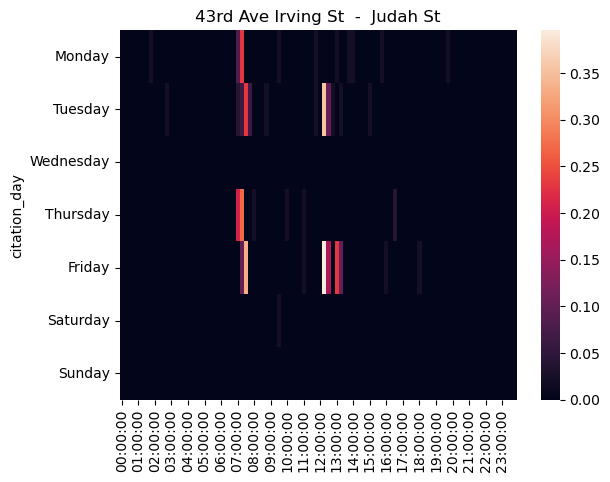

In [257]:
def plot_dist(all_dists, street_id):
    temp_df = all_dists[all_dists.street_id == street_id]
    # has all 7 days of the week
    assert temp_df.shape[0] == 7
    temp_df = temp_df[[col for col in temp_df.columns if col not in ['street_id', 'time_bin']]]
    temp_df.set_index('citation_day', inplace=True)
    sns.heatmap(temp_df).set(title=street_id)

plot_dist(all_dists, '43rd Ave Irving St  -  Judah St')


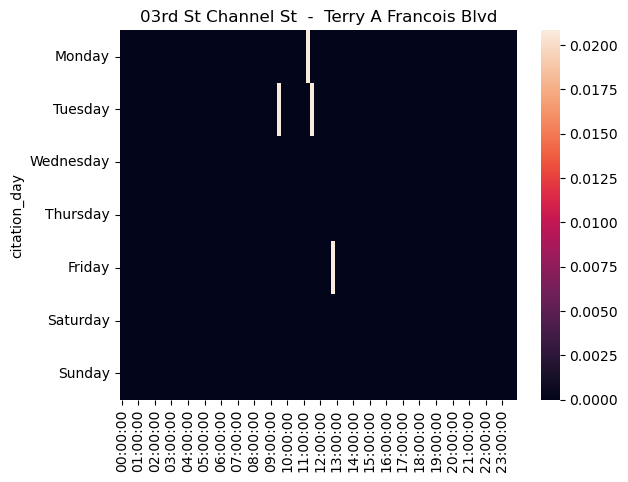

In [258]:
plot_dist(all_dists, '03rd St Channel St  -  Terry A Francois Blvd')

In [153]:
# looking for one street_id

# all_dists[all_dists.street_id.str.contains('Terry A Francois Blvd')].street_id[0]

In [160]:
NUMERIC_COLS = [col for col in all_dists.columns if '0' in col]

In [173]:
# add geom information to all_dists

unique_streets['street_id'] = unique_streets['Corridor'] + ' ' + unique_streets['Limits']
street_geom_dict = pd.Series(unique_streets.Line.values,index=unique_streets.street_id).to_dict()
all_dists['geom'] = all_dists['street_id'].apply(lambda key: street_geom_dict[key])

In [177]:
all_dists

,citation_day,street_id,time_bin,00:00:00,00:15:00,00:30:00,00:45:00,01:00:00,01:15:00,01:30:00,...,21:45:00,22:00:00,22:15:00,22:30:00,22:45:00,23:00:00,23:15:00,23:30:00,23:45:00,geom
0,Monday,01st St Clementina St - Folsom St,"{'00:00:00': 1, '00:15:00': 1, '00:30:00': 1, ...",0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,"LINESTRING (-122.395007841381 37.787717615642,..."
1,Tuesday,01st St Clementina St - Folsom St,"{'00:00:00': 1, '00:15:00': 2, '00:30:00': 1, ...",0.0,0.020833,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,"LINESTRING (-122.395007841381 37.787717615642,..."
2,Wednesday,01st St Clementina St - Folsom St,"{'00:00:00': 1, '00:15:00': 1, '00:30:00': 1, ...",0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,"LINESTRING (-122.395007841381 37.787717615642,..."
3,Thursday,01st St Clementina St - Folsom St,"{'00:00:00': 1, '00:15:00': 2, '00:30:00': 1, ...",0.0,0.020833,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,"LINESTRING (-122.395007841381 37.787717615642,..."
4,Friday,01st St Clementina St - Folsom St,"{'00:00:00': 1, '00:15:00': 1, '00:30:00': 1, ...",0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,"LINESTRING (-122.395007841381 37.787717615642,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,Wednesday,Zoe St Welsh St - Freelon St,"{'00:00:00': 1, '00:15:00': 1, '00:30:00': 1, ...",0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,"LINESTRING (-122.396306203949 37.780096449982,..."
3,Thursday,Zoe St Welsh St - Freelon St,"{'00:00:00': 1, '00:15:00': 12, '00:30:00': 9,...",0.0,0.229167,0.166667,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,"LINESTRING (-122.396306203949 37.780096449982,..."
4,Friday,Zoe St Welsh St - Freelon St,"{'00:00:00': 1, '00:15:00': 1, '00:30:00': 1, ...",0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020833,0.0,"LINESTRING (-122.396306203949 37.780096449982,..."
5,Saturday,Zoe St Welsh St - Freelon St,"{'00:00:00': 1, '00:15:00': 1, '00:30:00': 1, ...",0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,"LINESTRING (-122.396306203949 37.780096449982,..."


In [178]:
# equivalent to pivot_longer in R

pivoted = pd.melt(all_dists[all_dists.citation_day == 'Friday'], id_vars=['citation_day', 'street_id', 'geom'], value_vars=NUMERIC_COLS, value_name='prob', var_name='time')
pivoted['time'] = pd.to_datetime(pivoted['time'])

In [179]:
# save to csv for visualization by kepler GL

pivoted.to_csv('../data/pivoted_for_kgl.csv', index=False)

In [180]:
pivoted['prob'].value_counts()

0.000000    1002730
0.020833      40029
0.041667       9885
0.062500       4067
0.083333       2242
0.104167       1264
0.125000        898
0.145833        695
0.166667        505
0.187500        414
0.208333        306
0.229167        243
0.250000        206
0.270833        177
0.291667        136
0.312500         99
0.333333         95
0.354167         67
0.375000         66
0.395833         57
0.416667         47
0.437500         40
0.458333         39
0.479167         34
0.520833         30
0.500000         29
0.562500         20
0.541667         19
0.583333         15
0.645833         12
0.604167         11
0.687500         10
0.666667         10
0.729167          7
0.770833          6
0.750000          6
0.708333          5
0.854167          5
0.625000          5
0.812500          2
0.916667          2
0.979167          2
0.833333          2
0.875000          2
0.791667          1
0.895833          1
1.000000          1
Name: prob, dtype: int64